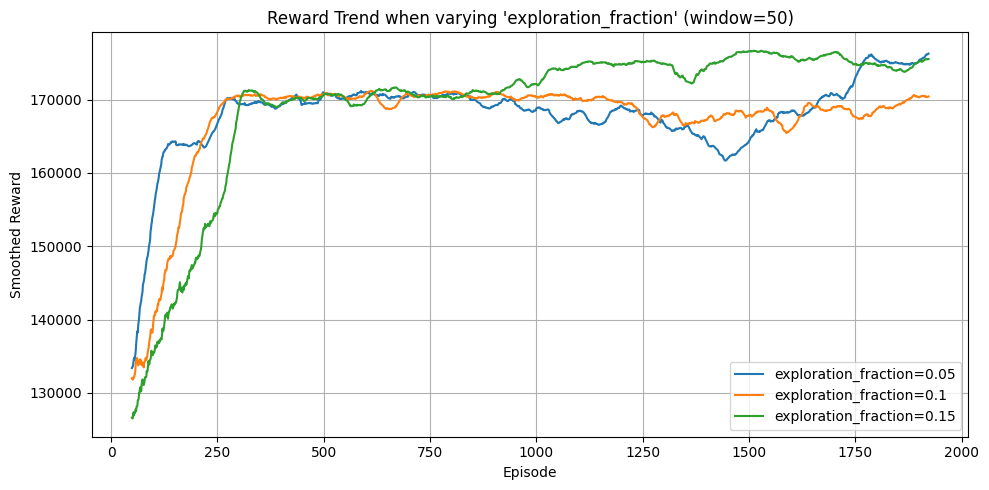

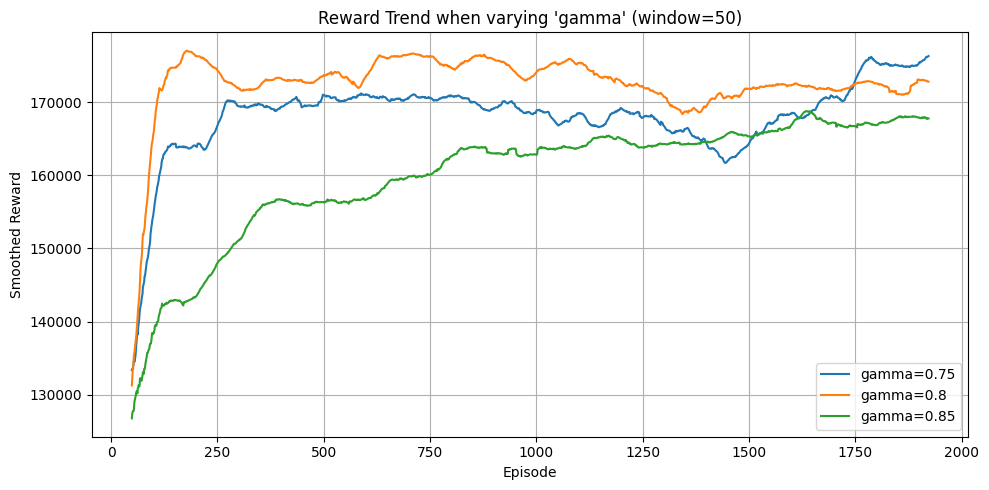

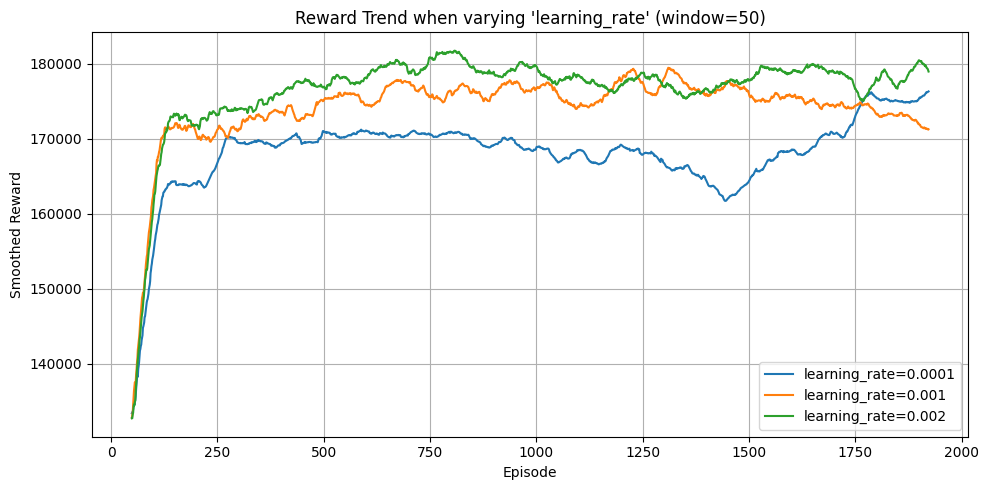

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import re
from itertools import product

# === Original grid
param_grid = {
    "exploration_fraction": [0.05, 0.1, 0.15],
    "exploration_final_eps": [0.01],
    "gamma": [0.75, 0.8, 0.85],
    "buffer_size": [50000],
    "learning_rate": [1e-4, 1e-3, 2e-3]
}

param_names = list(param_grid.keys())
grid = list(product(*param_grid.values()))
window = 50

# === Read logs
log_dir = "logs/dqn"
pattern = os.path.join(log_dir, "monitor_DQN_grid_search_*.csv")
log_files = sorted(glob.glob(pattern))

# Filter only runs 0–27
filtered_logs = [
    lf for lf in log_files
    if (match := re.search(r'DQN_grid_search_(\d+)', lf)) and int(match.group(1)) <= 27
]

# === Map log file to config
log_configs = []
for log_file in filtered_logs:
    match = re.search(r'DQN_grid_search_(\d+)', log_file)
    if match:
        idx = int(match.group(1))
        if idx >= len(grid):
            continue  # Ignore logs with no matching config
        config = dict(zip(param_names, grid[idx]))
        log_configs.append((idx, config, log_file))

# === Helper to compare configs
def is_only_param_different(cfg1, cfg2, param):
    return all(
        (cfg1[k] == cfg2[k] if k != param else cfg1[k] != cfg2[k])
        for k in cfg1
    )

# === New: collect all runs where only one parameter differs
def collect_runs_for_param(param_name):
    collected = {}
    for base_idx, base_cfg, base_file in log_configs:
        candidates = []
        for idx, test_cfg, test_file in log_configs:
            if is_only_param_different(base_cfg, test_cfg, param_name):
                candidates.append((test_cfg[param_name], test_file))
        if len(candidates) >= len(param_grid[param_name]) - 1:
            # Found a complete (or almost complete) group
            collected[base_cfg[param_name]] = base_file
            for val, f in candidates:
                collected[val] = f
            break
    return collected

# === Plotting function
def plot_param_variation(param_name):
    runs = collect_runs_for_param(param_name)
    if not runs:
        print(f"⚠️ No runs found varying only: {param_name}")
        return

    plt.figure(figsize=(10, 5))
    for val, file in sorted(runs.items()):
        try:
            df = pd.read_csv(file, skiprows=1)
            df["rolling_reward"] = df["r"].rolling(window).mean()
            label = f"{param_name}={val}"
            plt.plot(df["rolling_reward"], label=label)
        except Exception as e:
            print(f"⚠️ Error loading {file}: {e}")
            continue

    plt.title(f"Reward Trend when varying '{param_name}' (window={window})")
    plt.xlabel("Episode")
    plt.ylabel("Smoothed Reward")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Plot each parameter
plot_param_variation("exploration_fraction")
plot_param_variation("gamma")
plot_param_variation("learning_rate")

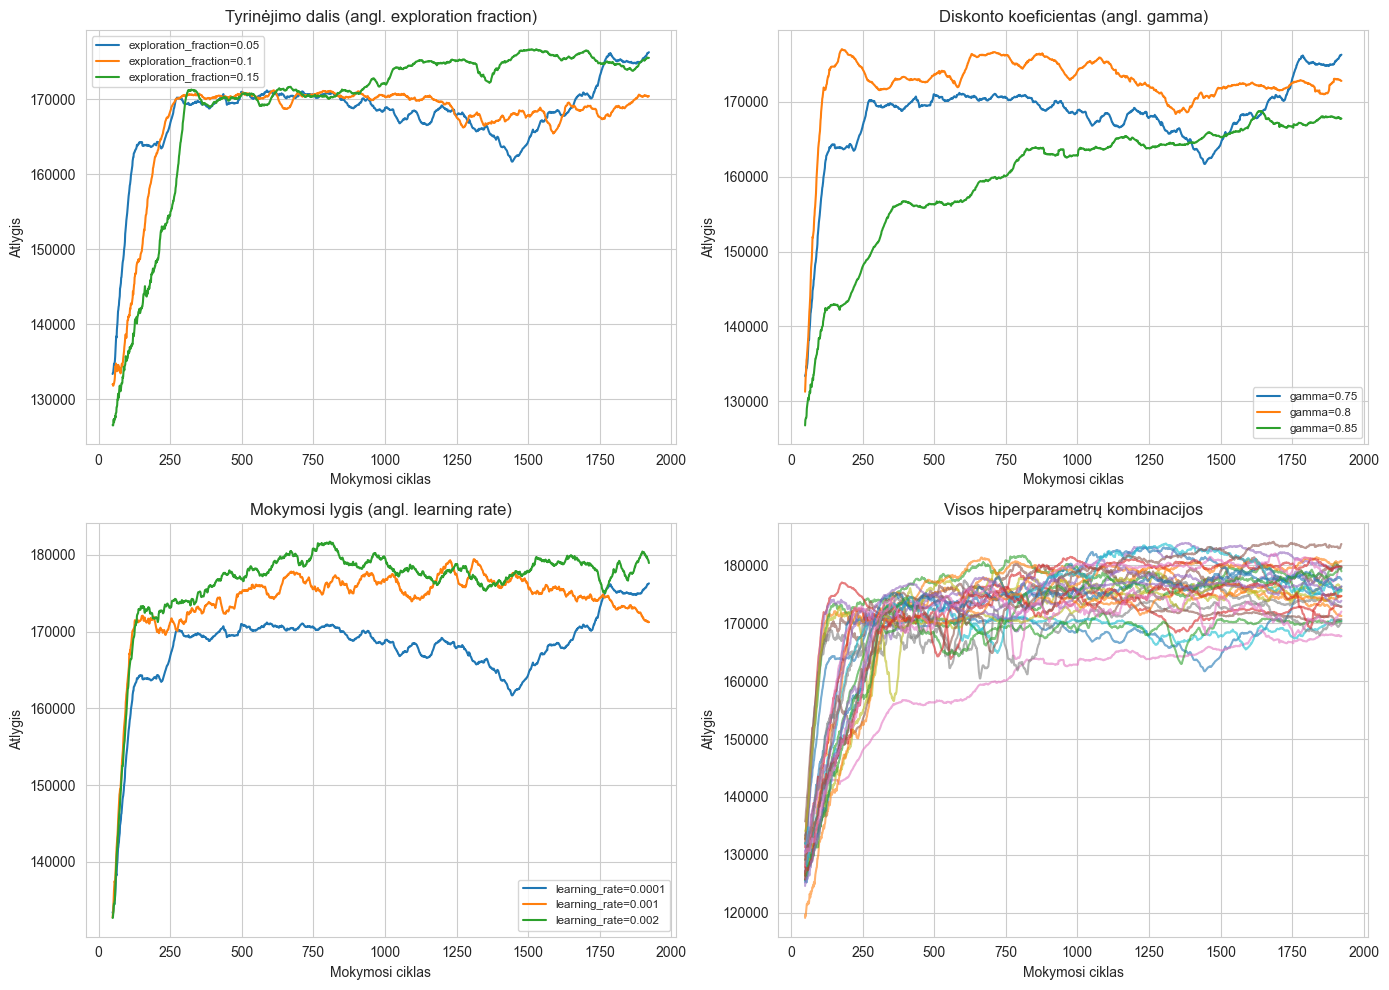

In [46]:
def plot_all_together_2x2(window=50):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    params = ["exploration_fraction", "gamma", "learning_rate"]
    titles = {
        "exploration_fraction": "Tyrinėjimo dalis (angl. exploration fraction)",
        "gamma": "Diskonto koeficientas (angl. gamma)",
        "learning_rate": "Mokymosi lygis (angl. learning rate)",
        "all": "Visos hiperparametrų kombinacijos"
    }

    # 1–3 pavieniai parametrai
    for ax, param in zip(axes.flatten()[:3], params):
        runs = collect_runs_for_param(param)
        for val, file in sorted(runs.items()):
            try:
                df = pd.read_csv(file, skiprows=1)
                df["rolling_reward"] = df["r"].rolling(window).mean()
                label = f"{param}={val}"
                ax.plot(df["rolling_reward"], label=label)
            except Exception as e:
                print(f"⚠️ Error loading {file}: {e}")
                continue
        ax.set_title(f"{titles[param]}")
        ax.set_xlabel("Mokymosi ciklas")
        ax.set_ylabel("Atlygis")
        ax.grid(True)
        ax.legend(fontsize="small")

    # 4: visi run'ai
    ax_all = axes.flatten()[3]
    for _, _, log_file in log_configs:
        try:
            df = pd.read_csv(log_file, skiprows=1)
            df["rolling_reward"] = df["r"].rolling(window).mean()
            ax_all.plot(df["rolling_reward"], alpha=0.6)
        except Exception as e:
            print(f"⚠️ Skipping {log_file}: {e}")
            continue
    ax_all.set_title(titles["all"])
    ax_all.set_xlabel("Mokymosi ciklas")
    ax_all.set_ylabel("Atlygis")
    ax_all.grid(True)

    plt.tight_layout()
    plt.show()

# Paleidžiam
plot_all_together_2x2()

In [2]:
best_avg_reward = -float("inf")
best_run = None

for log_file in log_files:
    try:
        df = pd.read_csv(log_file, skiprows=1)
        avg_reward = df["r"].tail(50).mean()  # mean of last 50 episodes
        run_name = os.path.basename(log_file)

        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            best_run = run_name
    except Exception as e:
        continue

print(f"🏅 Best model: {best_run} with avg reward (last 50 eps): {best_avg_reward:.2f}")

🏅 Best model: monitor_DQN_grid_search_025.csv.monitor.csv with avg reward (last 50 eps): 183656.98


In [3]:
from itertools import product

# Define your original parameter grid again
param_grid = {
    "exploration_fraction": [0.05, 0.1, 0.15],
    "exploration_final_eps": [0.01],
    "gamma": [0.75, 0.8, 0.85],
    "buffer_size": [50000],
    "learning_rate": [1e-4, 1e-3, 2e-3]
}

param_names = list(param_grid.keys())
grid = list(product(*param_grid.values()))

# Extract run index from filename, e.g., "monitor_DQN_grid_search_014.csv"
import re
match = re.search(r'DQN_grid_search_(\d+)', best_run)
if match:
    best_index = int(match.group(1))
    best_config = dict(zip(param_names, grid[best_index]))

    print(f"🧠 Best model config (index {best_index}):")
    for key, val in best_config.items():
        print(f"  {key}: {val}")
else:
    print("❌ Could not extract index from run name.")

🧠 Best model config (index 25):
  exploration_fraction: 0.15
  exploration_final_eps: 0.01
  gamma: 0.85
  buffer_size: 50000
  learning_rate: 0.001



=== Fold 1/10 ===
Fold 0: Test avg reward = 100086.76, std = 362.66

=== Fold 2/10 ===
Fold 1: Test avg reward = 167670.05, std = 971.98

=== Fold 3/10 ===
Fold 2: Test avg reward = 176520.13, std = 847.77

=== Fold 4/10 ===
Fold 3: Test avg reward = 151823.32, std = 435.66

=== Fold 5/10 ===
Fold 4: Test avg reward = 154790.98, std = 725.45

=== Fold 6/10 ===
Fold 5: Test avg reward = 168303.10, std = 485.35

=== Fold 7/10 ===
Fold 6: Test avg reward = 156352.21, std = 708.30

=== Fold 8/10 ===
Fold 7: Test avg reward = 157478.43, std = 485.30

=== Fold 9/10 ===
Fold 8: Test avg reward = 130684.01, std = 591.41

=== Fold 10/10 ===
Fold 9: Test avg reward = 170415.10, std = 430.69

=== Cross-validation rezultatai (5 fold) ===
   fold     avg_reward  std_reward
0     0  100086.762016  362.664226
1     1  167670.045827  971.980067
2     2  176520.134225  847.772237
3     3  151823.317765  435.664479
4     4  154790.975797  725.451361
5     5  168303.099930  485.353614
6     6  156352.21

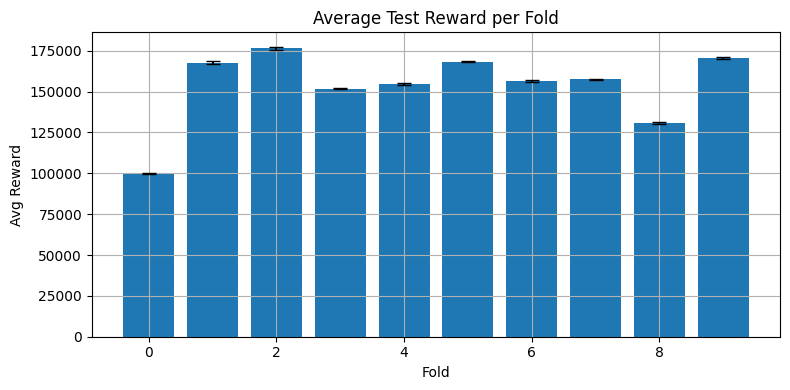

In [16]:
import pandas as pd
import numpy as np
import os
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from env.ecommerce_env_all2 import AdvancedPricingEnv
import matplotlib.pyplot as plt

# === 1. Duomenų paruošimas su fold žymomis
df = pd.read_csv("data/generated/weekly_env_data_filled.csv")
df["week_start"] = pd.to_datetime(df["year_week"] + "-1", format="%Y-%W-%w")
df = df.sort_values("week_start")

df["fold"] = pd.qcut(df["week_start"].rank(method="first"), q=10, labels=False)

os.makedirs("data/cv", exist_ok=True)
results = []

# === 2. K-Fold ciklas
for fold in range(10):
    print(f"\n=== Fold {fold+1}/10 ===")
    
    train_df = df[df["fold"] != fold]
    test_df = df[df["fold"] == fold]

    train_path = f"data/cv/train_fold_{fold}.csv"
    test_path = f"data/cv/test_fold_{fold}.csv"
    train_df.to_csv(train_path, index=False)
    test_df.to_csv(test_path, index=False)

    # === 2.1 Aplinkos paruošimas
    train_env = DummyVecEnv([
        lambda: Monitor(
            AdvancedPricingEnv(data_path=train_path, verbose=False),
            filename=f"logs/dqn/train_monitor_fold_{fold}.csv"
        )
    ])

    test_env = Monitor(
        AdvancedPricingEnv(data_path=test_path, verbose=False),
        filename=f"logs/dqn/test_monitor_fold_{fold}.csv"
    )

    # === 2.2 Modelio treniravimas (čia geriausi tavo hiperparametrai)
    model = DQN(
        "MlpPolicy",
        train_env,
        learning_rate=1e-3,
        buffer_size=50000,
        learning_starts=1000,
        batch_size=64,
        gamma=0.85,
        train_freq=4,
        target_update_interval=1000,
        exploration_fraction=0.15,
        exploration_final_eps=0.01,
        verbose=0,
        tensorboard_log=None
    )

    model.learn(total_timesteps=100_000)

    # === 2.3 Testavimas
    rewards = []
    for _ in range(20):
        done = False
        ep_reward = 0
        obs, _ = test_env.reset()
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, _ = test_env.step(action)
            ep_reward += reward
        rewards.append(ep_reward)

    avg_reward = np.mean(rewards)
    std_reward = np.std(rewards)

    print(f"Fold {fold}: Test avg reward = {avg_reward:.2f}, std = {std_reward:.2f}")
    results.append({
        "fold": fold,
        "avg_reward": avg_reward,
        "std_reward": std_reward
    })

# === 3. Apibendrinimas
results_df = pd.DataFrame(results)
mean = results_df["avg_reward"].mean()
std = results_df["avg_reward"].std()

print(f"\n=== Cross-validation rezultatai (5 fold) ===")
print(results_df)
print(f"\n📊 Vidutinis test reward: {mean:.2f} ± {std:.2f}")

# (nebūtina) Rezultatų vizualizacija
plt.figure(figsize=(8, 4))
plt.bar(results_df["fold"], results_df["avg_reward"], yerr=results_df["std_reward"], capsize=5)
plt.title("Average Test Reward per Fold")
plt.xlabel("Fold")
plt.ylabel("Avg Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

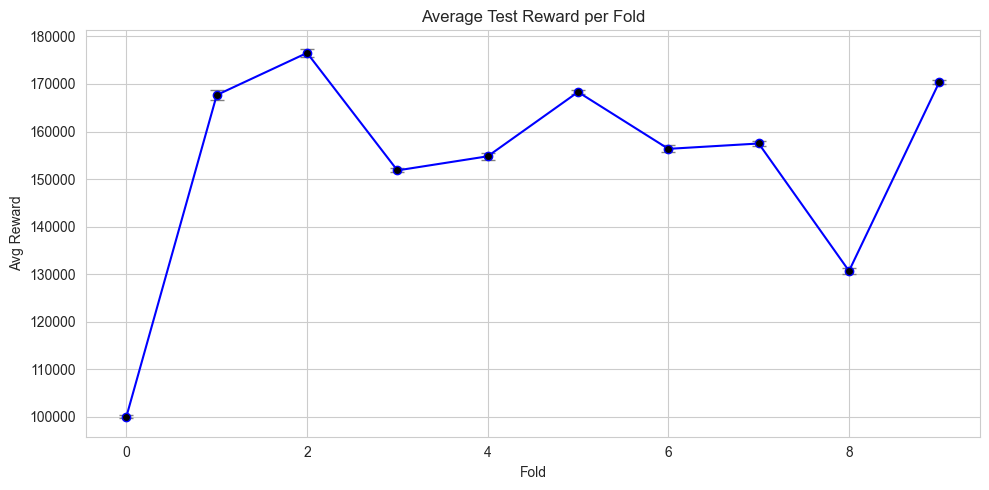

In [34]:
# === 3. Rezultatų vizualizacija – linijinis grafikas su klaidų juostomis
plt.figure(figsize=(10, 5))
plt.errorbar(
    results_df["fold"],
    results_df["avg_reward"],
    yerr=results_df["std_reward"],
    fmt='-o', capsize=5, ecolor='gray', color='blue', markerfacecolor='black'
)
plt.title("Average Test Reward per Fold")
plt.xlabel("Fold")
plt.ylabel("Avg Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from env.ecommerce_env_all2 import AdvancedPricingEnv
import os

# === 1. Įkeliam modelį ir aplinką ===
model = DQN.load("models/dqn/DQN_run_real/dqn_pricing_model.zip")

# Aplinka be DummyVecEnv
env = AdvancedPricingEnv(data_path="data/split/test.csv", verbose=False)
test_env = Monitor(env, filename=None)
encoder = env.encoder  # gauti OneHotEncoder objektą

# === 2. Rinkti duomenis: stebėjimai, Q reikšmės, veiksmai, reward ===
data = []
obs, _ = test_env.reset()

for _ in range(1000):
    obs_tensor = torch.tensor(obs, dtype=torch.float32)

    if len(obs_tensor.shape) == 1:
        obs_tensor = obs_tensor.unsqueeze(0)

    q_val = model.q_net(obs_tensor).detach().numpy()[0]
    action, _ = model.predict(obs, deterministic=True)

    obs_arr = obs
    category_vec = obs_arr[7:]  # one-hot kategorija
    category = encoder.inverse_transform([category_vec])[0][0]  # atstatom vardą

    obs_dict = {
        "avg_price": obs_arr[0],
        "base_price": obs_arr[1],
        "base_demand": obs_arr[2],
        "price_elasticity": obs_arr[3],
        "stock": obs_arr[4],
        "prev_reward": obs_arr[5],
        "demand_level": obs_arr[6],
        "category": category,
        "q_values": q_val,
        "action": int(action)
    }

    obs, reward, done, _, _ = test_env.step(action)
    obs_dict["reward"] = reward
    data.append(obs_dict)

    if done:
        obs, _ = test_env.reset()

# === 3. Duomenų paruošimas analizėms ===
df = pd.DataFrame(data)
q_matrix = np.stack(df["q_values"].values)

# === 3.1 Pridėti main_category
translation = pd.read_csv("data/unique_categories_translated_2.csv", sep=";")
translation = translation.drop_duplicates(subset="translated_name")
df = df.merge(
    translation[["translated_name", "main_category"]],
    how="left",
    left_on="category",
    right_on="translated_name"
)
df.drop(columns=["translated_name"], inplace=True)

# === 4. PCA ir t-SNE
pca = PCA(n_components=2)
q_pca = pca.fit_transform(q_matrix)

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca', random_state=42)
q_tsne = tsne.fit_transform(q_matrix)

# === 5. KMeans klasterizacija
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df["cluster"] = kmeans.fit_predict(q_matrix)

# === 6. Vizualizacijos
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(q_tsne[:, 0], q_tsne[:, 1], c=df["action"], cmap="tab10", alpha=0.7)
plt.title("t-SNE (Q-values) pagal veiksmą")
plt.colorbar(label="Veiksmas")

plt.subplot(1, 2, 2)
plt.scatter(q_tsne[:, 0], q_tsne[:, 1], c=df["cluster"], cmap="Set2", alpha=0.7)
plt.title("t-SNE (Q-values) pagal klasterį")
plt.colorbar(label="Klasteris")

plt.tight_layout()
os.makedirs("analysis/q_value", exist_ok=True)
plt.savefig("analysis/q_value/tsne_clusters.png")
plt.close()

# === 7. Klasterių charakteristikos su main_category
cluster_stats = df.groupby("cluster").agg({
    "avg_price": "mean",
    "base_price": "mean",
    "base_demand": "mean",
    "price_elasticity": "mean",
    "stock": "mean",
    "reward": ["mean", "std"],
    "action": lambda x: x.value_counts().index[0],
    "main_category": lambda x: x.value_counts().index[0]
})

print("\n📊 Klasterių charakteristikos:")
print(cluster_stats)

# === 8. Išsaugoti CSV
output_path = "data/generated/q_analysis/q_values_with_clusters.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.drop(columns=["q_values"]).to_csv(output_path, index=False)
print(f"\n✅ Duomenys su klasteriais išsaugoti: {output_path}")


📊 Klasterių charakteristikos:
          avg_price  base_price base_demand price_elasticity       stock  \
               mean        mean        mean             mean        mean   
cluster                                                                    
0        125.334366  125.267738  124.954910        -1.557825  149.856766   
1        246.115280  253.398972  134.312500        -1.844792  170.708328   
2         89.700348   89.455513  114.302788        -1.743028  140.187256   
3        113.569008  112.599724  120.318840        -1.368116  153.797104   

              reward                action main_category  
                mean          std <lambda>      <lambda>  
cluster                                                   
0        2662.982556  1706.341771        7  Construction  
1        4757.744630  3935.406504        7   Electronics  
2        2014.338617  1628.042813        3          Home  
3        2523.943811  1417.053897        6       Fashion  

✅ Duomenys su klasteri

In [30]:
import seaborn as sns

# === 6b. PCA klasterių vaizdavimas ===
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(q_pca[:, 0], q_pca[:, 1], c=df["action"], cmap="tab10", alpha=0.7)
plt.title("PCA (Q-values) pagal veiksmą")
plt.colorbar(label="Veiksmas")

plt.subplot(1, 2, 2)
plt.scatter(q_pca[:, 0], q_pca[:, 1], c=df["cluster"], cmap="Set2", alpha=0.7)
plt.title("PCA (Q-values) pagal klasterį")
plt.colorbar(label="Klasteris")

plt.tight_layout()
plt.savefig("analysis/q_value/pca_clusters.png")
plt.close()

# === 9. Reward pasiskirstymas pagal klasterį ===
plt.figure(figsize=(8, 5))
sns.boxplot(x="cluster", y="reward", data=df)
plt.title("Reward pasiskirstymas per klasterius")
plt.xlabel("Klasteris")
plt.ylabel("Reward (€)")
plt.tight_layout()
plt.savefig("analysis/q_value/reward_by_cluster.png")
plt.close()

# === 10. Reward pasiskirstymas pagal pagrindinę kategoriją (main_category) ===
top_main = df["main_category"].value_counts().nlargest(10).index
filtered_df = df[df["main_category"].isin(top_main)]

plt.figure(figsize=(10, 6))
sns.boxplot(x="main_category", y="reward", data=filtered_df)
plt.title("Reward pasiskirstymas per TOP 10 pagrindinių kategorijų")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("analysis/q_value/reward_by_main_category.png")
plt.close()

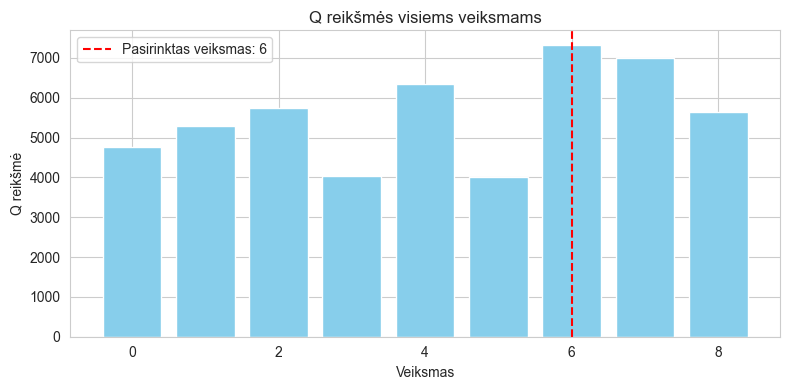

In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from env.ecommerce_env_all2 import AdvancedPricingEnv

# === 1. Įkeliam modelį
model = DQN.load("models/dqn/DQN_run_real/dqn_pricing_model.zip")
q_net = model.q_net  # PyTorch modelis

# === 2. Aplinka (testavimui)
env = AdvancedPricingEnv(data_path="data/split/test.csv", verbose=False)
obs, _ = env.reset()

# === 3. Paverčiam į tensor ir skaičiuojam Q reikšmes
obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)  # (1, N)
with torch.no_grad():
    q_values = q_net(obs_tensor).numpy()[0]  # (9,)

# === 4. Modelio veiksmo pasirinkimas
action, _ = model.predict(obs, deterministic=True)

# === 5. Vizualizacija
plt.figure(figsize=(8, 4))
plt.bar(range(len(q_values)), q_values, color="skyblue")
plt.axvline(action, color="red", linestyle="--", label=f"Pasirinktas veiksmas: {action}")
plt.title("Q reikšmės visiems veiksmams")
plt.xlabel("Veiksmas")
plt.ylabel("Q reikšmė")
plt.legend()
plt.tight_layout()
plt.show()

TypeError: 'numpy.float32' object is not iterable

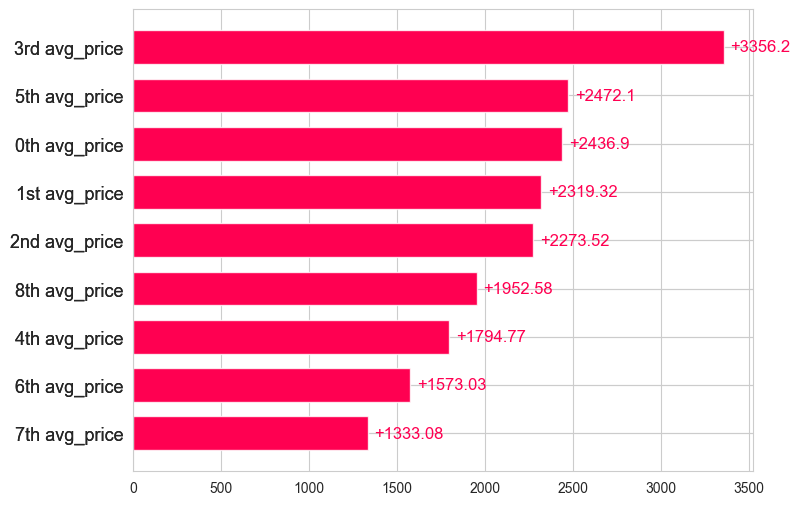

In [44]:
import shap
import torch
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from env.ecommerce_env_real2 import AdvancedPricingEnv  # adaptuok prie savo aplinkos

# Įkeliame modelį
model = DQN.load("models/dqn/DQN_run_real/dqn_pricing_model.zip")
model.q_net.eval()

# Aplinkos paruošimas
env = AdvancedPricingEnv(data_path="data/generated/weekly_env_data_filled.csv", verbose=False)

# Feature pavadinimai (rankiniu būdu + iš encoder)
base_features = [
    "avg_price", "base_price", "base_demand",
    "price_elasticity", "stock", "previous_reward", "demand_level"
]
category_names = env.encoder.get_feature_names_out(["translated_name"])
feature_names = base_features + list(category_names)

# Surenkame stebėjimus
obs_list = []
obs = env.reset()[0]
for _ in range(100):
    obs_list.append(obs)
    action, _ = model.predict(obs, deterministic=True)
    obs, _, done, _, _ = env.step(action)
    if done:
        obs = env.reset()[0]

# Teisingas masyvo formatas
X = np.vstack(obs_list)  # užtikrina 2D formatą

# SHAP predict funkcija — grąžina visas Q reikšmes (visiems veiksmams)
def predict_fn(x):
    x = torch.tensor(x, dtype=torch.float32)
    with torch.no_grad():
        q_vals = model.q_net(x)
        return q_vals.numpy()

# Veiksmų pavadinimai
n_actions = env.action_space.n
output_names = [f"action_{i}" for i in range(n_actions)]

# SHAP analizė visiems veiksmams
explainer = shap.Explainer(predict_fn, X, output_names=output_names)
shap_values = explainer(X)
shap_values.feature_names = feature_names

# Vizualizacija — pasirenk veiksmą (pvz., action_0)
action_idx = 0  # arba 1, 2, ...
plt.figure(figsize=(12, 10))
shap.plots.bar(shap_values[:, action_idx], show=False)
plt.title(f"SHAP reikšmės veiksmui: action_{action_idx}")
plt.tight_layout()
plt.show()